In [ ]:
from src.networks.speech_separation import SpeechbrainSepformer
from src.dataset import LibriWHAM
from torchmetrics.functional import scale_invariant_signal_distortion_ratio
import torch

dataset = LibriWHAM(length_seconds=4.096, train=False, return_pair=True)
x0, x1 = dataset[0]
x0 = x0.unsqueeze(0)
x1 = x1.unsqueeze(0)
model = SpeechbrainSepformer()
with torch.no_grad():
    out = model.separate(x1)

from IPython.display import Audio, display  
display(Audio(x1.squeeze().numpy(), rate=16000))
display(Audio(out.squeeze().detach().numpy(), rate=16000, normalize=False))

sisdri = scale_invariant_signal_distortion_ratio(out, x0, zero_mean=True) - scale_invariant_signal_distortion_ratio(x1, x0, zero_mean=True)
print(sisdri)

INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/sepformer-wham16k-enhancement' if not cached


Setting SNR range to -2 to 5 dB for LibriWHAM test set


In [ ]:
from src.lightning_modules.dsb_scheduler import DSBScheduler
scheduler = DSBScheduler(epsilon=1.0)

In [ ]:
scheduler.get_conditional('backward', 1, None)

tensor([0])

In [ ]:
scheduler.get_timeschedule(10, 'cosine', 'backward')

[(1.0, 0.9755282998085022),
 (0.9755282998085022, 0.9045084714889526),
 (0.9045084714889526, 0.7938926219940186),
 (0.7938926219940186, 0.6545085310935974),
 (0.6545085310935974, 0.5),
 (0.5, 0.34549152851104736),
 (0.34549152851104736, 0.20610737800598145),
 (0.20610737800598145, 0.09549149870872498),
 (0.09549149870872498, 0.02447172999382019),
 (0.02447172999382019, 0.0)]

In [100]:
from torch import Tensor, nn
from torch.nn import Module
import torch

class STFTEncoderDecoder(Module):
    def __init__(
        self,
        n_fft : int,
        hop_length : int,
        p: int = 1,
    ):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = n_fft
        self.p = p
        
    def encode(self, audio : Tensor) -> Tensor:
        if not hasattr(self, 'original_length'):
            self.original_length = audio.shape[-1]
        
        audio = torch.cat((audio, torch.zeros(audio.shape[0], audio.shape[1], self.n_fft - 1, device=audio.device)), dim=-1)
        audio = audio.squeeze(1)
        window = torch.hamming_window(self.win_length, device=audio.device)
        stft = torch.stft(
            audio, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.win_length, 
            center=False,
            window=window,
            return_complex=True
            )
        
        real, imag = stft.real, stft.imag
        
        real = real.sign() * real.abs().pow(self.p)
        imag = imag.sign() * imag.abs().pow(self.p)

        out = torch.stack([real, imag], dim=1)

        return out
    
    def decode(self, encoded : Tensor) -> Tensor:
        real, imag = encoded[:, 0], encoded[:, 1]
        
        real = real.sign() * real.abs().pow(1 / self.p)
        imag = imag.sign() * imag.abs().pow(1 / self.p)
        
        stft = real + 1j * imag

        window = torch.hamming_window(self.win_length, device=stft.device)
        audio = torch.istft(
            stft, 
            n_fft=self.n_fft, 
            hop_length=self.hop_length, 
            win_length=self.win_length, 
            center=False,
            window=window
        )
        audio = torch.nn.functional.pad(audio, (0, self.original_length - audio.shape[-1]), mode='constant', value=0)
        return audio.unsqueeze(1)

In [101]:
from src.dataset import LibriWHAM
encoder = STFTEncoderDecoder(n_fft=510, hop_length=128, p=0.5)
dataset = LibriWHAM(length_seconds=4.096, train=False, return_pair=True)
x0, x1 = dataset[1]
x0 = x0.unsqueeze(0)
encoded = encoder.encode(x0)
decoded = encoder.decode(encoded)

print(torch.allclose(x0, decoded, atol=1e-5))

Setting SNR range to -2 to 5 dB for LibriWHAM test set
True


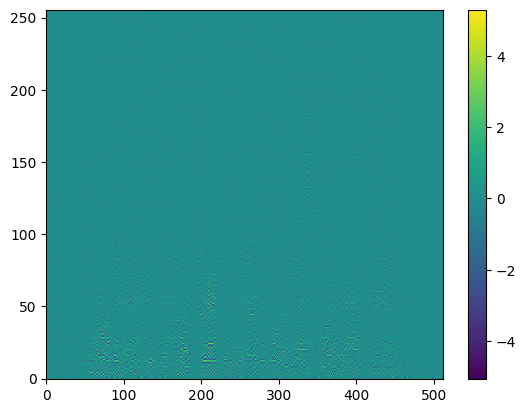

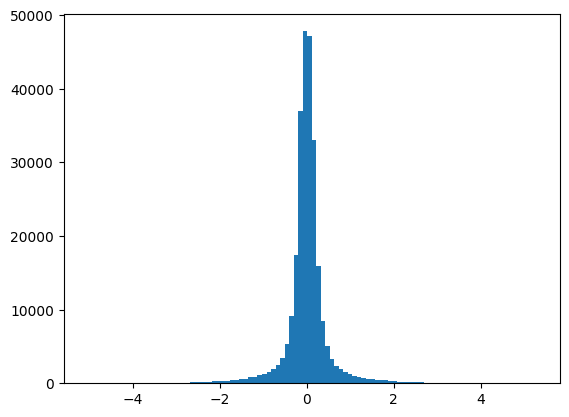

In [102]:
import matplotlib.pyplot as plt
plt.imshow(encoded[0, 1].detach().numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.show()

plt.hist(encoded.flatten().detach().numpy(), bins=100)
plt.show()